Dog/cat classification

Algo: Convulational neural network, VGG-16

Optimization: Adam

In [1]:
# ! pip install -q kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle competitions download -c dogs-vs-cats

'pip' is not recognized as an internal or external command,
operable program or batch file.
The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.
'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import os
import cv2
import zipfile
import random
import glob
import shutil
import tensorflow as tf
from tqdm import tqdm # bar process percentage
import numpy as np
from os import makedirs
from matplotlib import pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import opendatasets as od   # get kaggle datasets, remember to download their json key file as well

print(len(tf.config.experimental.list_physical_devices('GPU')))

0


Định nghĩa về các dữ liệu đầu vào *X* và nhãn dữ liệu *y*

In [3]:
zip_ref = zipfile.ZipFile('content\\dogs-vs-cats.zip', "r").extractall('content\\dogs-vs-cats')
zip_ref = zipfile.ZipFile('content\\dogs-vs-cats' + '\\train.zip', "r").extractall('content\\dogs-vs-cats')
zip_ref = zipfile.ZipFile('content\\dogs-vs-cats' + '\\test1.zip', "r").extractall('content\\dogs-vs-cats')

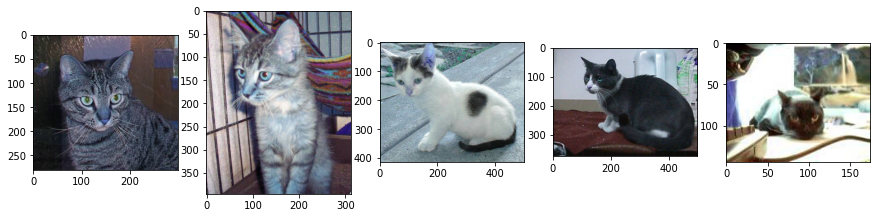

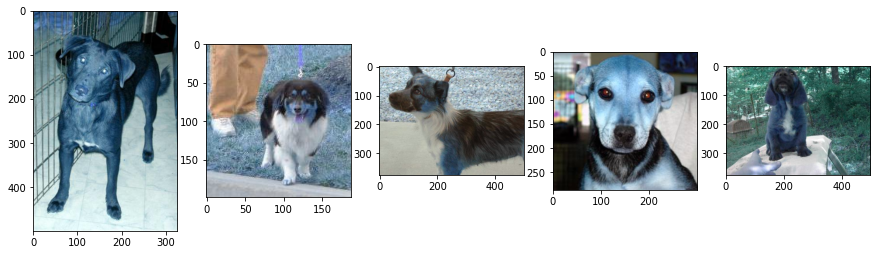

In [4]:
# labelling + samples
train_folder = 'content\\dogs-vs-cats\\train\\'

plt.figure(figsize=(15,10))

for i in range(1,6):
    plt.subplot(1,5,i)
    sample_location = train_folder + 'cat.' + str(i) + '.jpg'
    sample_image = cv2.imread(sample_location)
    plt.imshow(sample_image)
plt.show()

plt.figure(figsize=(15,10))

for i in range(1,6):
    plt.subplot(1,5,i)
    sample_location = train_folder + 'dog.' + str(i) + '.jpg'
    sample_image = cv2.imread(sample_location)
    plt.imshow(sample_image)
plt.show()

In [9]:
# the dataset has already been divided into train and test folders
train_path = 'content\\dogs-vs-cats\\train\\'
train_ratio = 0.75
sub_dirs = ['train\\', 'test\\']
class_dirs = ['dogs\\', 'cats\\']

# restructure the data folders for ImageDataGenerator (tensorflow)
for sub_dir in sub_dirs:
    for class_dir in class_dirs:
        makedirs(train_path + sub_dir + class_dir, exist_ok=True)

In [6]:
# dividing random data from train folder into 2 parts: 25% for validation and 75% for training
# suffle then 

train_ratio = 0.75

cats = glob.glob(train_path + 'cat.*')  # get a list of files with same string and *
dogs = glob.glob(train_path + 'dog.*')

random.shuffle(cats)
random.shuffle(dogs)

cats_percentile75 = int((len(cats)+1)*train_ratio)
dogs_percentile75 = int((len(dogs)+1)*train_ratio)
cats_train = cats[:cats_percentile75]  # get image file from begining to element 75th percentile, also convert the float to integer with int()
dogs_train = dogs[:dogs_percentile75]
cats_test = cats[cats_percentile75:] # the remaining 25th percentile cat images
dogs_test = dogs[dogs_percentile75:]

print("Training sets | dogs = {}, cats = {}".format(len(dogs_train), len(cats_train)))
print("Test/validation sets | dogs = {}, cats = {}".format(len(dogs_test), len(cats_test)))
print(cats_train[0])

Training sets | dogs = 9375, cats = 9375
Test/validation sets | dogs = 3125, cats = 3125
content\dogs-vs-cats\train\cat.11312.jpg


In [8]:
# move these data to the new folder structure
data_path = os.getcwd() + '\\'

for img_file in tqdm(cats_train):
    shutil.move(img_file, data_path + train_path + sub_dirs[0] + class_dirs[1])
for img_file in tqdm(cats_test):
    shutil.move(img_file, data_path + train_path + sub_dirs[1] + class_dirs[1])
for img_file in tqdm(dogs_train):
    shutil.move(img_file, data_path + train_path + sub_dirs[0] + class_dirs[0])
for img_file in tqdm(dogs_test):
    shutil.move(img_file, data_path + train_path + sub_dirs[1] + class_dirs[0])

  0%|          | 0/9375 [00:00<?, ?it/s]


Error: Destination path 'c:\hieu_practice\MLOps-course\dogcat\content\dogs-vs-cats\train\train\cats\cat.11312.jpg' already exists

CNN model by Keras

In [10]:
# default optimizer
optimizer = Adam(learning_rate=0.001)

def get_model():
    model = Sequential()

    # first layer
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # second layer
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    # third layer
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    # final layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

Training, evaluating model

In [11]:
# load model
model = get_model()

# create data generators
train_data_generator = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1,
                                          height_shift_range=0.1, horizontal_flip=True)
test_data_generator = ImageDataGenerator(rescale=1.0/255.0)

# prepare iterators
train_path = 'content\\dogs-vs-cats\\train\\'
train_it = train_data_generator.flow_from_directory(train_path + '\\train\\', class_mode='binary',
                                                    batch_size=64, target_size=(200,200))
test_it = test_data_generator.flow_from_directory(train_path + '\\test\\', class_mode='binary',
                                                  batch_size=64, target_size=(200,200))

# fit model
history = model.fit(train_it, steps_per_epoch=len(train_it), 
                    validation_data=test_it, validation_steps=len(test_it),
                    epochs=50, verbose=1)

# evaluate model 
# accuracy
_, accuracy = model.evaluate(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (accuracy * 100.0))
model.save('content\\model\\catdogclassification.h5')


Found 18750 images belonging to 2 classes.
Found 6250 images belonging to 2 classes.
Epoch 1/50
293/293 [==============================] - 1007s 3s/step - loss: 1.0880 - accuracy: 0.5387 - val_loss: 0.6448 - val_accuracy: 0.6195
Epoch 2/50
293/293 [==============================] - 946s 3s/step - loss: 0.6421 - accuracy: 0.6295 - val_loss: 0.5631 - val_accuracy: 0.6946
Epoch 3/50
293/293 [==============================] - 932s 3s/step - loss: 0.5967 - accuracy: 0.6822 - val_loss: 0.5704 - val_accuracy: 0.7123
Epoch 4/50
293/293 [==============================] - 1029s 4s/step - loss: 0.5715 - accuracy: 0.7011 - val_loss: 0.5511 - val_accuracy: 0.7227
Epoch 5/50
293/293 [==============================] - 966s 3s/step - loss: 0.5565 - accuracy: 0.7165 - val_loss: 0.5184 - val_accuracy: 0.7352
Epoch 6/50
293/293 [==============================] - 915s 3s/step - loss: 0.5421 - accuracy: 0.7249 - val_loss: 0.4886 - val_accuracy: 0.7672
Epoch 7/50
293/293 [==============================] - 1

Plotting results

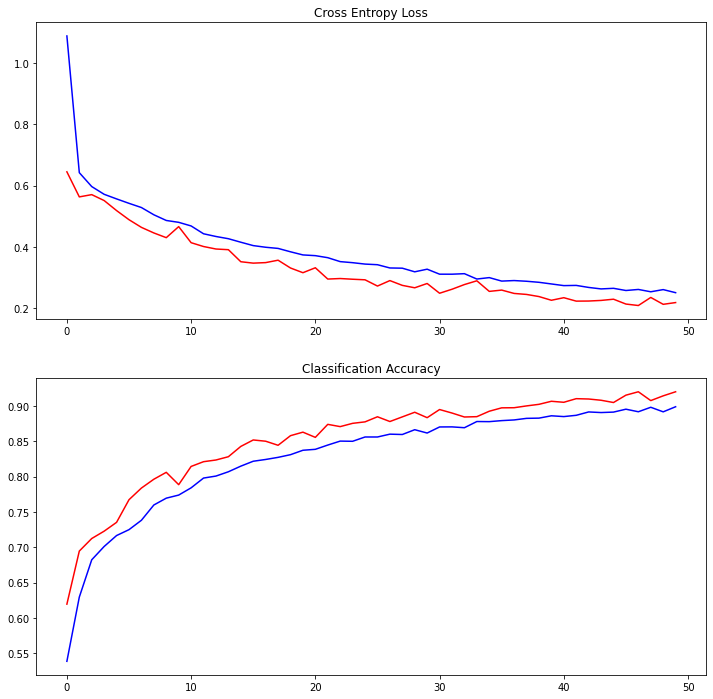

In [21]:
# Evaluation, learning curves
fig, ax = plt.subplots(2,1, figsize=(12,12))
# loss
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='red', label='validate')
# accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='red', label='validate')
plt.show()


Test model

In [3]:
from keras.models import load_model

trained_model = load_model('content\model\catdogclassification.h5')

1/1 [==============================] - 0s 34ms/step


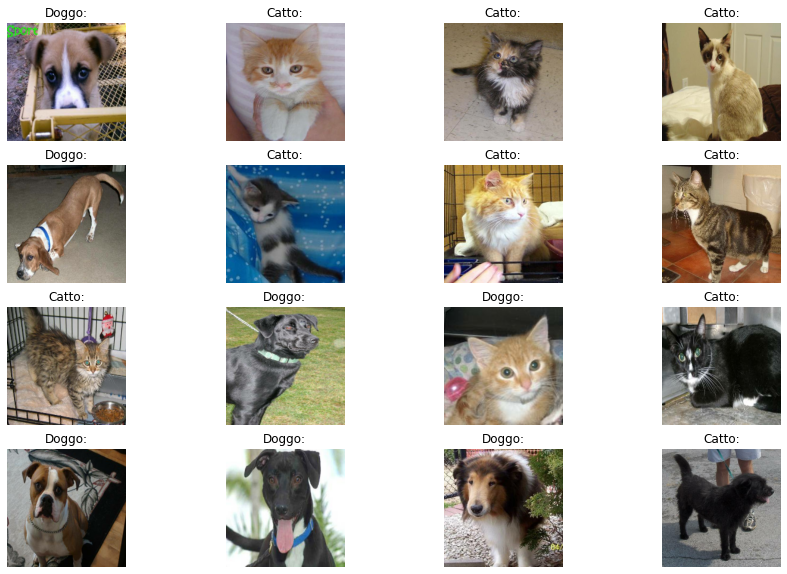

In [11]:
IMAGE_SIZE = 200

# preprocessing images
def preprocess(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image /= 255.0
    return image

# preocess images from folder test1
def final_image(path):
    image = tf.io.read_file(path)
    return preprocess(image)

image_test_path = glob.glob("content\\dogs-vs-cats\\test1\\*.jpg")

rows = 4
plt.figure(figsize=(15,10))
for i, x in enumerate(image_test_path[16:32]):
    image = final_image(x)
    prediction = trained_model.predict(np.array([image]))

    confidence_dog = str(prediction[0]*100)[1:-1][0:5]
    confidence_cat = str(100-prediction[0]*100)[1:-1][0:5]

    if prediction[0] > 0.5: class_name = f'Doggo, confidence {confidence_dog}%'
    else: class_name = f'Catto, confidence {confidence_cat}%'

    plt.subplot(rows, 4, i+1)
    plt.title(class_name)
    plt.axis('off')
    plt.imshow(image)

plt.show()
